In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, f1_score, matthews_corrcoef
from helper_functions.Classification_eval import lift_score, eval_metrics, plot_shap_summary_and_importance

In [2]:
train = pd.read_csv('Datasets\\paysim_train.csv')
test = pd.read_csv('Datasets\\paysim_test.csv')

In [3]:
train.head()

,Unnamed: 0,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,157,5530.25,C657793176,0.0,0.00,M739568006,0.00,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
1,1,260,110352.76,C1412043435,0.0,0.00,C41698878,2574546.99,2684899.76,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
2,2,44,5406.11,C450614947,81630.0,76223.89,M691104477,0.00,0.00,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0
3,3,350,8221.22,C1796508227,3697.0,0.00,M1692201305,0.00,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
4,4,238,7787.64,C381041925,82938.0,75150.36,M382945339,0.00,0.00,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0


In [4]:
all_columns_fit = [col for col in train.columns if col not in ['step', 
                                                               'isFraud', 'isFlaggedFraud', 'nameOrig', 
                                                               'nameDest', 'Unnamed: 0' 
                                                               ,'amount'
                                                               ,'oldbalanceOrig',
                                                                'newbalanceOrig',
                                                                'oldbalanceDest',
                                                                'newbalanceDest'
                                                                ,'prev_orig_avg_amount'
                                                                ,'prev_dest_avg_amount'
                                                                ]]
all_columns_fit

['merchOrig',
 'merchDest',
 'merchInvolved',
 'origBalanceCleared',
 'amount_eq_bal',
 'prev_orig_steps_num',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchInvolved_total',
 'prev_orig_merch_orig_sum',
 'prev_orig_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchInvolved_total',
 'prev_dest_merch_orig_sum',
 'prev_dest_merchDest_sum',
 'log_oldbalanceOrig',
 'log_newbalanceOrig',
 'log_oldbalanceDest',
 'log_newbalanceDest',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'missingindicator_prev_orig_steps_num',
 'missingindicator_prev_orig_avg_amount',
 'missingindicator_prev_orig_fraud_max',
 'missingindicator_prev_orig_txn_hour_avg',
 'missingindicator_prev_orig_merchInvolved_total',
 'missingindicator_prev_orig_merch_orig_sum',
 'missingindicator_prev_orig_merchDest_sum',
 'missingindicator_prev_dest_ste

In [5]:

# Define hyperparamaters to search
# I cast a wide net on the hyperparamaters, since I am using Randomized search

# Define the parameter grid to search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5],
}


xgb_clf = xgb.XGBClassifier( 
                            random_state =123, 
                            objective='binary:logistic',
                            )

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled, reduced for my computer
    scoring='f1',  # Metric used for evaluation
    cv=3,  # Number of cross-validation folds, keeping it small for my computer
    verbose=1,
    random_state=123,
    n_jobs=4  # Use all available cores
)


# xgb_model = xgb_clf.fit(train[all_columns_fit], train['isFraud'] )


CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time
random_search_fit = random_search.fit(train[all_columns_fit], train['isFraud'])

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Model metrics Summary (train): 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083516
           1       1.00      1.00      1.00      6580

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Model metrics Summary (test): 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270891
           1       1.00      1.00      1.00      1633

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



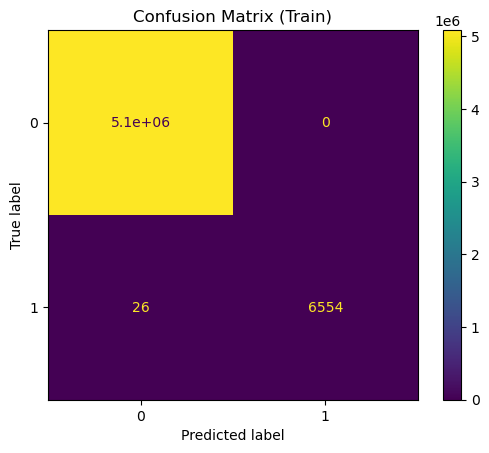

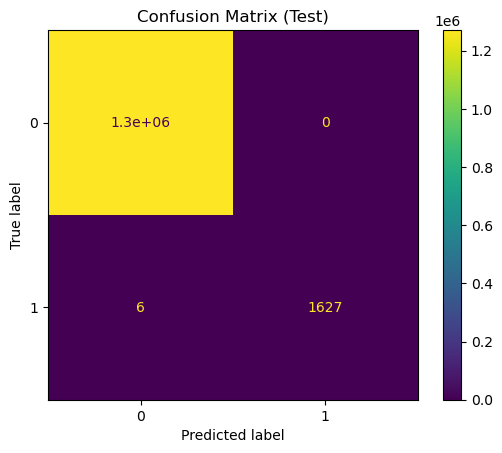

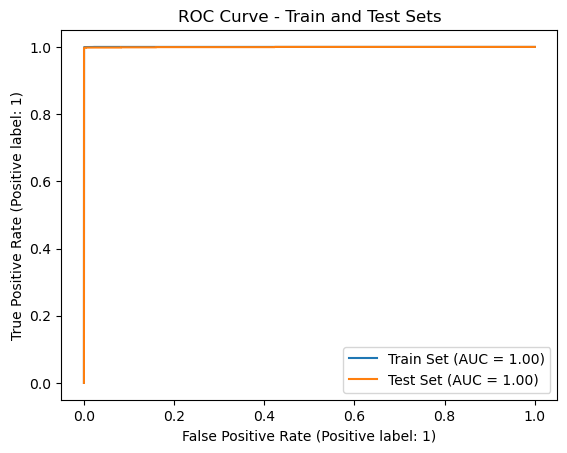

Model Lift Report (Train): 
%s    decile  response_rate   count       lift
0       1       0.012927  509009  10.000012
1       2       0.000000  508438   0.000000
2       3       0.000000  509582   0.000000
3       4       0.000000  509009   0.000000
4       5       0.000000  509010   0.000000
5       6       0.000000  268977   0.000000
6       7       0.000000  749042   0.000000
7       8       0.000000  509000   0.000000
8       9       0.000000  466678   0.000000
9      10       0.000000  551351   0.000000 

Model Lift Report (Test): 
%s    decile  response_rate   count      lift
0       1       0.012817  127253  9.987706
1       2       0.000008  127247  0.006124
2       3       0.000000  127257  0.000000
3       4       0.000000  127253  0.000000
4       5       0.000008  127252  0.006124
5       6       0.000000   67565  0.000000
6       7       0.000000  186940  0.000000
7       8       0.000000  127252  0.000000
8       9       0.000000  116031  0.000000
9      10       0.00000

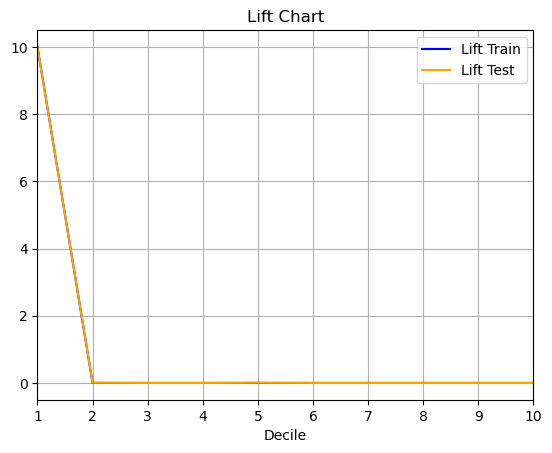

In [7]:
eval_metrics(random_search_fit, 
             train[all_columns_fit],
             train['isFraud'],
             test[all_columns_fit], 
             test['isFraud'])

The Area under Precision-Recall curve is more suitable in instances where the data is severely imbalanced, as in this case.  So I would like to generate that as well, and it is not in the general function definition of the helper funcitons I have created to evaluate metrics

In [8]:
y_pred_probs = random_search_fit.predict(test[all_columns_fit])

precision, recall, _ = precision_recall_curve( test['isFraud'], y_pred_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
average_precision = average_precision_score(test['isFraud'], y_pred_probs)

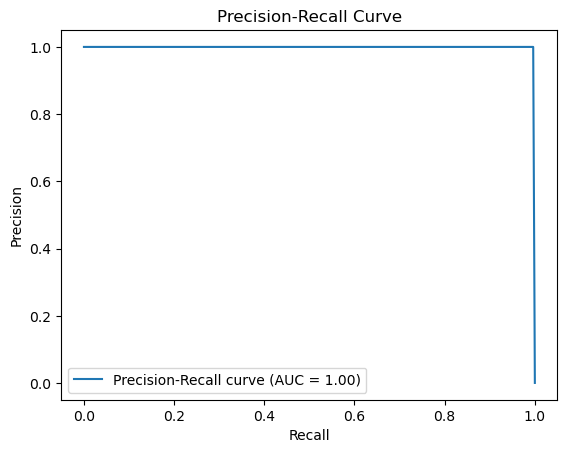

AUC-PR: 0.9981652479051797
Average Precision Score: 0.9963304958103594


In [9]:
# Plotting the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

print(f"AUC-PR: {auc_pr}")
print(f"Average Precision Score: {average_precision}")

Due to the large class imbalance, the fit statistics indicate an almost perfectly performing model on the test dataset.  This could be coincidence, however it could also be valid performance.  Considering that this model has barely been tuned, more investigation is needed.

I start with investigating the Shapley values of the features, to see if there is a feature that could have caused some leaking

[14:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


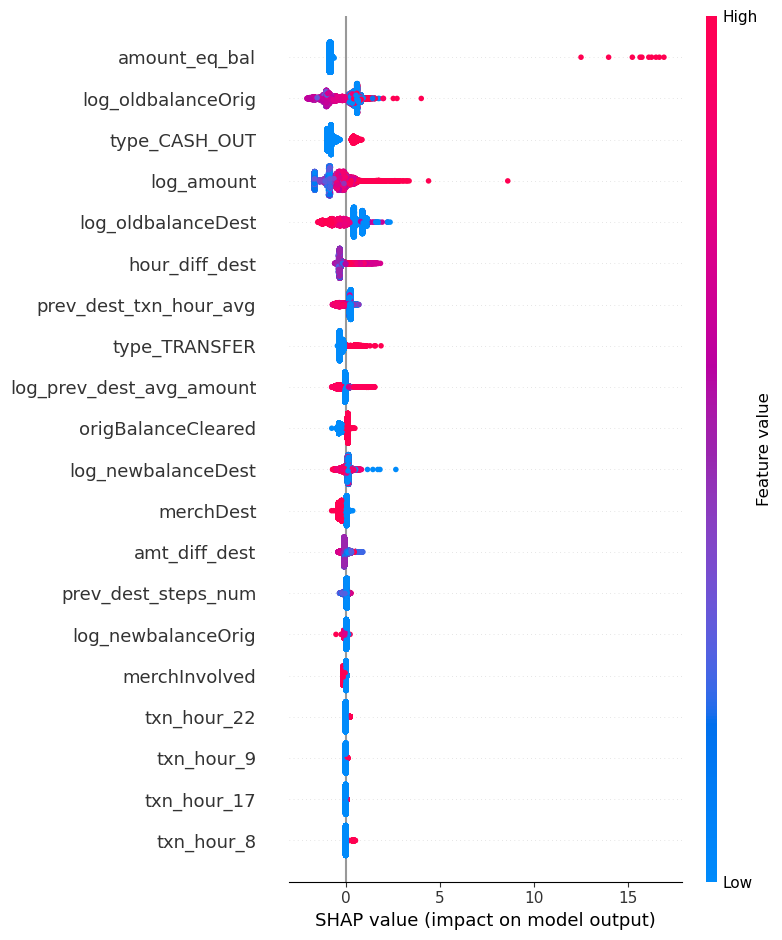

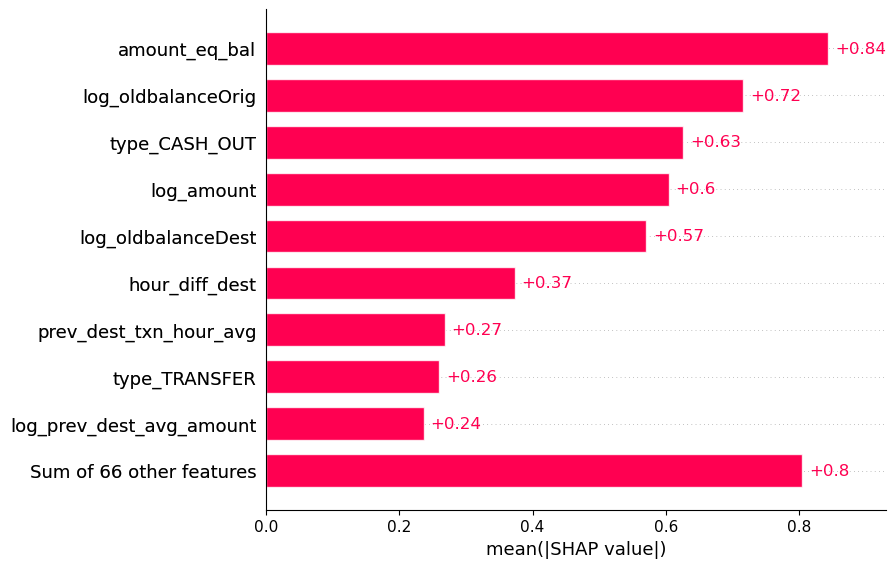

In [11]:
plot_shap_summary_and_importance(random_search_fit.best_estimator_, test[all_columns_fit],  max_display=20, random_state=123)

None of the features seem overly predictive of the target, however I will still do a quick profile of each of the top 4 most predictive ones, along with target distribution between the training andd test set

In [25]:
train['isFraud'].sum() / len(train)

0.0012927064636894864

In [26]:
test['isFraud'].sum() / len(test)

0.0012832763861428153

The distribution of targets in both are similar